In [ ]:
import torch
from torch import nn, optim, autograd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, n_filter=64):
        super(ResBlock, self).__init__()

        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(n_filter, n_filter, 5, padding=2),#nn.Linear(DIM, DIM),
            nn.ReLU(True),
            nn.Conv2d(n_filter, n_filter, 5, padding=2),#nn.Linear(DIM, DIM),
        )

    def forward(self, input):
        output = self.res_block(input)
        return input + (0.3*output)

In [3]:
class ResGenerator(nn.Module):
    def __init__(self, input_shape, n_filter=64, n_residual=7):
        super(self.__class__, self).__init__()
        
        self.input_shape = input_shape
        self.n_filter = n_filter
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, n_filter, 9, padding=4),
            nn.LeakyReLU()
        )
        
        self.residual = nn.Sequential(
            *[ResBlock() for _ in range(n_residual)]
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_filter, n_filter, 3, padding=1),
            nn.BatchNorm2d(n_filter),
        )
        
        self.out = nn.Sequential(
            nn.Conv2d(n_filter, 3, 3, padding=1)
        )
        
    def forward(self, input):
        conv1 = self.conv1(input)
        res = self.residual(conv1)
        conv2 = self.conv2(res)
        out = self.out(conv2)
        
        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, wasserstein=True, n_filter=64):
        super(self.__class__, self).__init__()
        
        self.input_shape = input_shape
        
        self.wasserstein = wasserstein
        self.n_filter = n_filter
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, n_filter, 3, padding=1),
            
            nn.Sequential(
                *[
                    nn.Sequential(
                        nn.Conv2d(n_filter, n_filter, 3, padding=1),
                        nn.BatchNorm2d(n_filter),
                        nn.LeakyReLU()
                    )

                    for _ in range(7)
                ]
            )
        )
        
        _, chan, x, y = input_shape
        
        self.linear = nn.Sequential(
            nn.Linear(x * y * n_filter, 1024),
            nn.Sequential(nn.Linear(1024, 1)) if wasserstein else nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())
        )
                
    def forward(self, input):
        _, _, x, y = self.input_shape
        
        hid = self.layers(input).view(-1, x * y * self.n_filter)
        out = self.linear(hid)
        
        return out

In [5]:
def gradient_penalty(disc, real_data, generated_data, device=device):
    batch_size = real_data.size(0)
    
    epsilon = torch.rand(batch_size, 1, device=device, requires_grad=True)
    epsilon_exp = epsilon.expand(batch_size, real_data.nelement()/batch_size).contiguous().view(real_data.size())
    
    interpolates = epsilon_exp * real_data + (1 - epsilon_exp) * generated_data
    
    disc_interpolates = disc(interpolates)
    
    gradients = autograd.grad(outputs=disc_interpolates.mean(), 
                              inputs=interpolates, 
                              create_graph=True, retain_graph=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)

    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [6]:
def wasserstein_loss(disc, real_data, fake_data, gp_lambda=10):
    return (disc(real_data) - disc(fake_data)).mean() + gradient_penalty(disc, real_data, fake_data) * gp_lambda

In [18]:
def cycle_loss(inputA, inputB, genA2B, genB2A):
    cycleA = genB2A(genA2B(inputA))
    cycleB = genA2B(genB2A(inputB))
    
    return (cycleA - cycleB).pow(2).mean()

In [19]:
def generator_combined_loss(inputA, inputB, genA2B, genB2A, discA, discB):
    return -discA(genB2A(inputB)).mean() - discB(genA2B(inputA)).mean() + cycle_loss(inputA, inputB, genA2B, genB2A)

def discriminator_combined_loss(inputA, inputB, discA, discB, genA2B, genB2A):
    genA = genB2A(inputB)
    genB = genA2B(inputA)
    
    return wasserstein_loss(discA, inputA, genA) + wasserstein_loss(discB, inputB, genB)

In [9]:
def sample_batch(size=16):
    x = torch.randn(size, 3, 32, 32, device=device)
    y = torch.randn(size, 3, 32, 32, device=device)
    
    return x, y

In [10]:
IMG_SHAPE = [1, 3, 32, 32]
ADAM_PARAMS = {"lr": 1e-4, "betas": (0.5, 0.9)}

In [11]:
generatorA2B = ResGenerator(IMG_SHAPE).cuda()
generatorB2A = ResGenerator(IMG_SHAPE).cuda()

discriminatorA = Discriminator(IMG_SHAPE).cuda()
discriminatorB = Discriminator(IMG_SHAPE).cuda()

adamGen = optim.Adam(list(generatorA2B.parameters()) + list(generatorB2A.parameters()), **ADAM_PARAMS)
adamDisc = optim.Adam(list(discriminatorA.parameters()) + list(discriminatorB.parameters()), **ADAM_PARAMS)

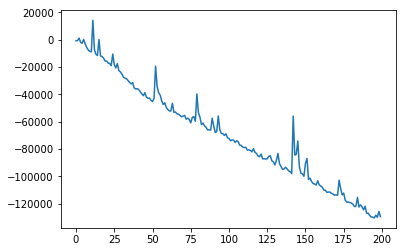

In [13]:
BATCH_SIZE = 8
N_EPOCHS = 350

d_loss_hist = list()

x, y = sample_batch(BATCH_SIZE)

for _ in range(N_EPOCHS):
    d_loss = discriminator_combined_loss(x, y, discriminatorA, discriminatorB, generatorA2B, generatorB2A)
    d_loss_hist.append(d_loss)
    d_loss.backward()
    
    adamDisc.step()
    adamDisc.zero_grad()
    
plt.plot([point.data.cpu().numpy() for point in d_loss_hist][:200])

In [20]:
BATCH_SIZE = 8
N_EPOCHS = 350

g_loss_hist = list()

x, y = sample_batch(BATCH_SIZE)

for _ in range(N_EPOCHS):
    g_loss = generator_combined_loss(x, y, generatorA2B, generatorB2A, discriminatorA, discriminatorB)
    g_loss_hist.append(g_loss)
    g_loss.backward()
    
    adamGen.step()
    adamGen.zero_grad()